<a href="https://colab.research.google.com/github/alexwhite116/youtube-transcription/blob/main/youtube_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YouTube Transcription Project

This notebook looks to achieve the following:
1. Create/implement a model to transcribe a YouTube video given a link and store the transcription.
2. (Stretch) Implement a search function to enter text and return the most relevant video link based on its transcription.
3. (Stretch) Implement a summary of videos retrieved via the search function, also presenting the video title and thumbnail.
4. (Stretch) Implement automation for a specific streamer so that transcriptions/summaries of all of their content are available (and searchable).
5. Deploy the above as part of a Gradio app (stretch goals optional/iterative).

## Imports

We import `torch`, `torchaudio` and `pytube`


*   `torch`: For machine learning model implementation
  *   `torchaudio`: We will be working with the audio of the videos for transcription
*   `pytube`: To enable us to work with YouTube streams
* `moviepy.editor`: To allow us to manipulate audio files
* `IPython`: To allow us to play audio files in order to understand our data


In [1]:
import os

import random

import numpy as np

import wave

import matplotlib.pyplot as plt

import moviepy.editor
import IPython

import torch
from torch import nn
import torchaudio
print(f"PyTorch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")

try:
  import pytube
  print(f"PyTube version: {pytube.__version__}")
except:
  !pip install pytube
  import pytube
  print(f"PyTube version: {pytube.__version__}")

PyTorch version: 2.2.1+cu121
torchaudio version: 2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 834.4 kB/s eta 0:00:00
PyTube version: 15.0.0


## Downloading from YouTube

We first define a function to download audio from any given YouTube URL using `pytube`.

In [2]:
def download_youtube_audio(link: str) -> str:
  """Downloads youtube video, converts to audio and returns path.

  Arg:
    link (str): Link in string format to YouTube video to be downloaded.

  Returns:
    str: Path to audio file in local directory
  """
  streams = pytube.YouTube(link).streams.filter(only_audio=True) # Get only audio streams of youtube video
  video_path = streams[0].download() # take the first audio stream. video as this .mp4 format
  audio_path = video_path[0:-3] + "wav" # .mp4 -> .wav
  audio = moviepy.editor.AudioFileClip(video_path)
  audio.write_audiofile(audio_path)
  audio.close()
  os.remove(video_path)
  return audio_path

Now we download the video *[I rank EVERY BOSS in Elden Ring from best to worst as the Doll from Bloodborne](https://www.youtube.com/watch?v=bql0s1aCR_4&t=1s)* from YouTube and save its audio.

In [3]:
link = "https://www.youtube.com/watch?v=bql0s1aCR_4&t=1s"

audio_path = download_youtube_audio(link)

MoviePy - Writing audio in /content/I rank EVERY BOSS in Elden Ring from best to worst as the Doll from Bloodborne.wav


MoviePy - Done.


Next, we define a function to play a snippet of our audio file. By default, this is a random 30 second clip.

In [4]:
def play_audio_snippet(audio_path: str,
                       start_time: float | None = None,
                       length: float = 30,
                       clip_path: str = "/content/sample_clip.wav") -> None:
  """Creates a sub-clip of a given audio file and outputs it to the audio player.

  Args:
    audio_path (str): Path to the audio file to be played
    start_time (float or None): Time (in seconds) of the original audio file
                                where the sub-clip should begin. Defaults to
                                None, which starts from a random point.
    length (float): Duration (in seconds) of the clip. Defaults to 30.
    clip_path (str): Path to save sub-clip to, including file extension.
                     Defaults to "/content/sample_clip.wav".
  """
  clip = moviepy.editor.AudioFileClip(audio_path)
  if start_time is None:
    start_time = random.uniform(0, clip.end-30)
  if not clip.is_playing(start_time) or not clip.is_playing(start_time + length): # check if clip times exist in video
    raise Exception("Invalid snippet time given")
  clip = clip.subclip(start_time, start_time + length)
  if os.path.exists(clip_path):
    os.remove(clip_path)
  clip.write_audiofile(clip_path)
  IPython.display.display(IPython.display.Audio(clip_path))

In [5]:
play_audio_snippet(audio_path)

MoviePy - Writing audio in /content/sample_clip.wav


MoviePy - Done.


We define a function to plot the wave form and frequency spectrogram of a given audio clip in order to visualise the data we will be inputting into our models.

In [6]:
def plot_audio_file(audio_path: str):
  """Plots wave form and frequency spectrogram of a given audio file.

  Args:
    audio_path (str): Path to the audio file to be plotted.
  """
  with wave.open(audio_path, 'rb') as wav_obj:
    print(f"Sample frequency: {(framerate := wav_obj.getframerate())}")
    print(f"Number of samples: {(nframes := wav_obj.getnframes())}")
    print(f"File length (seconds): {(filelength := nframes/framerate)}")
    print(f"Number of channels: {(nchannels := wav_obj.getnchannels())}")
    signal_wave = wav_obj.readframes(nframes)
    signal_array = np.frombuffer(signal_wave, dtype=np.int16)
    if nchannels != 2:
      raise Exception("Audio not in stereo")
    l_channel = signal_array[0::2]
    r_channel = signal_array[1::2]
    times = np.linspace(0, nframes/framerate, num=nframes)

    # Set up plot
    plt.figure(figsize=(15,10))

    # Plot left channel signal
    plt.subplot(2, 2, 1)
    plt.plot(times, l_channel)
    plt.title('Left Channel Signal Waveform')
    plt.ylabel('Signal Value')
    plt.xlabel('Time (s)')
    plt.xlim(0, filelength)

    # Plot right channel signal
    plt.subplot(2, 2, 2)
    plt.plot(times, r_channel)
    plt.title('Right Channel Signal Waveform')
    plt.ylabel('Signal Value')
    plt.xlabel('Time (s)')
    plt.xlim(0, filelength)

    # Plot left channel frequency spectrogram
    plt.subplot(2, 2, 3)
    plt.specgram(l_channel, Fs=framerate, vmin=-20, vmax=50)
    plt.title('Left Channel Frequency Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.xlim(0, filelength)
    plt.colorbar()

    # Plot right channel frequency spectrogram
    plt.subplot(2, 2, 4)
    plt.specgram(r_channel, Fs=framerate, vmin=-20, vmax=50)
    plt.title('Right Channel Frequency Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.xlim(0, filelength)
    plt.colorbar()

    plt.show()

Sample frequency: 44100
Number of samples: 1323000
File length (seconds): 30.0
Number of channels: 2


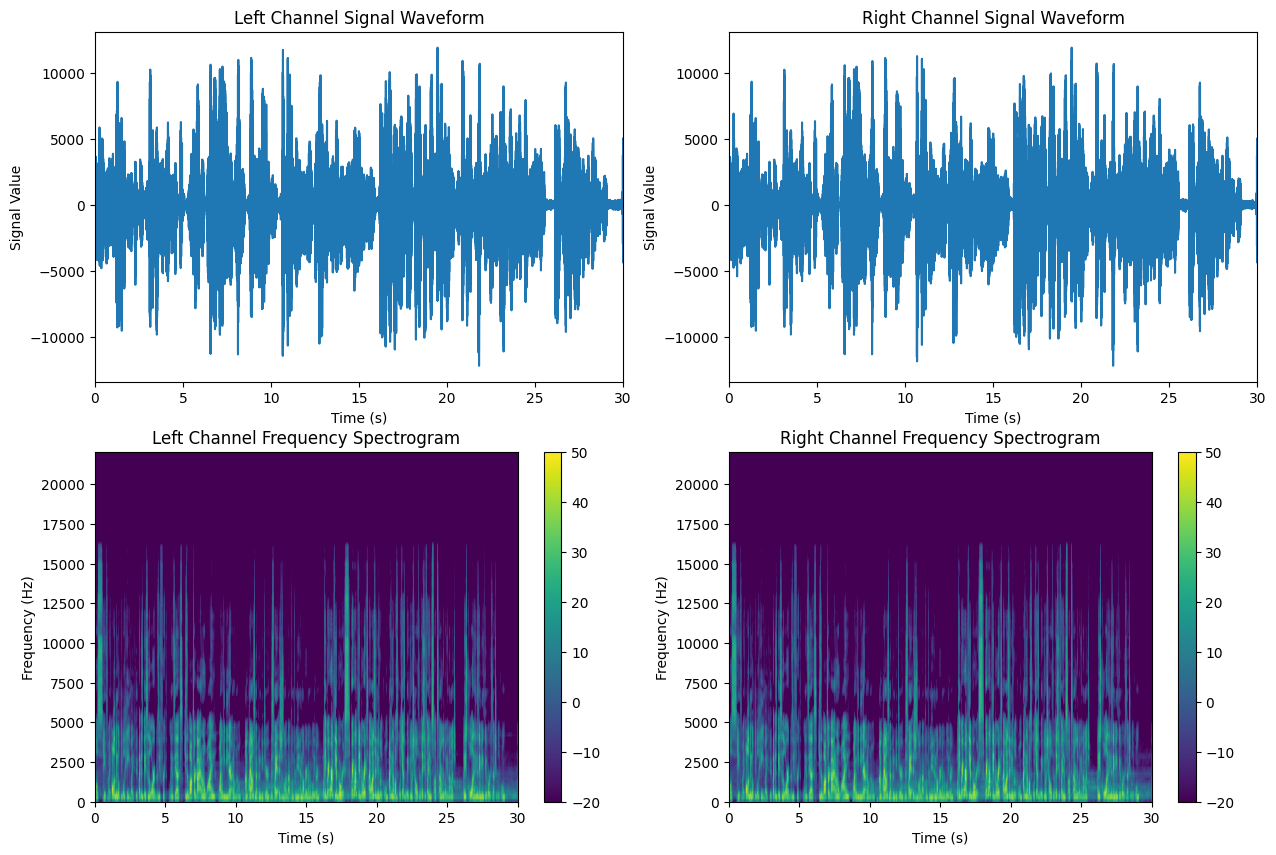

In [7]:
plot_audio_file('/content/sample_clip.wav')

## Transcribing text from audio

We will start by building our own speech-to-text (STT) model as a proof of concept. Due to memory and time constraints, this will likely underperform many state-of-the-art, publicly available models and so we later in this section we will look at applying and adapting other models (using transfer learning if we can identify suitable datasets) to apply to our context.

In order to narrow our scope for future fine-tuning of the datasets, we will focus on gaming YouTube videos as part of this notebook. Where we want to adapt other models, this will be the area of focus we target to improve language models.

### 1. Implementing wav2vec2.0

We will be creating vector representations of our audio by replicating the paper *'wav2vec 2.0: A Framework for Self-Supervised Learning of Speech Representations'* (https://arxiv.org/pdf/2006.11477). Specifically, we will look to implement the BASE wav2vec 2.0 model.

#### Importing our datasets
We will focus on training/testin against the 'clean' LibriSpeech dataset, using both unlabelled and labelled data as recommended by the paper.

In [8]:
if not os.path.isdir('data'):
  os.mkdir('data')

# Import train and test sets from PyTorch
train_dataset = torchaudio.datasets.LIBRISPEECH(
    root="data",
    url='dev-clean', # Full train data set is very large, we will use dev for this POC
    download=True
)

test_dataset = torchaudio.datasets.LIBRISPEECH(
    root="data",
    url="test-clean",
    download=True
)

100%|██████████| 322M/322M [00:13<00:00, 24.5MB/s]
100%|██████████| 331M/331M [00:13<00:00, 25.9MB/s]


We inspect the contents of a single item in the train dataset, which returns `Tuple[Tensor, int, str, int, int, int]`

We ignore the 4th and 5th elements of this tuple as our use case has a single speaker (potentially with video game audio which we will treat as noise). We are not interested in Chapter ID labels.

In [9]:
item = train_dataset.__getitem__(0)

print(f"Waveform tensor:\n{item[0]}")
print(f"Waveform tensor shape:{item[0].shape}")
print(f"Sample rate (Hz): {item[1]}")
print(f"Utterance length (seconds): {item[0].size(dim=1)/item[1]}")
print(f"Transcript:\n{item[2]}")
print(f"Utterance ID: {item[5]}")

Waveform tensor:
tensor([[0.0024, 0.0021, 0.0020,  ..., 0.0004, 0.0006, 0.0010]])
Waveform tensor shape:torch.Size([1, 93680])
Sample rate (Hz): 16000
Utterance length (seconds): 5.855
Transcript:
MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL
Utterance ID: 0


In [33]:
item1 = train_dataset.__getitem__(0)
item2 = train_dataset.__getitem__(1)

m = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=512, kernel_size=10, stride=5),
    nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2),
    nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2),
    nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2),
    nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2),
    nn.Conv1d(in_channels=512, out_channels=512, kernel_size=2, stride=2),
    nn.Conv1d(in_channels=512, out_channels=512, kernel_size=2, stride=2)
)

input1 = torch.unsqueeze(item1[0], dim=0)
input2 = torch.unsqueeze(item2[0], dim=0)

output1 = m(input1)
output2 = m(input2)

print(f"Input #1 shape: {input1.shape}")
print(f"Output #1 shape: {output1.shape}")

print(f"\nInput #2 shape: {input2.shape}")
print(f"Output #2 shape: {output2.shape}")

Input #1 shape: torch.Size([1, 1, 93680])
Output #1 shape: torch.Size([1, 512, 292])

Input #2 shape: torch.Size([1, 1, 77040])
Output #2 shape: torch.Size([1, 512, 240])
